In [1]:
from prody import *
import numpy as np
from os.path import basename
import fnmatch
import os
import networkx as nx
from networkx.algorithms import community
from itertools import chain, combinations

# Community composition analysis (i) between segments and (ii) residue by residue. RGB coloring scheme for _$\Omega$_ = 4

### __Beware that your pdb and dcd should have the same name and you can write a string pattern for batch calculation__

In the next cell, please write start, stop and stride of the dcd file that you want to analyze.
Point out the maximum community size you want to write to output files

In [2]:
starting_frame = 20 # write starting frame of your dcd
stopping_frame = 120 # last frame of your dcd
stride = 10 # stride of your dcd file
max_community_size = 5 #maximum number of communities/omega

Write the file string pattern or your pdb file. Please realize that, that file name also will be used for parsing related dcd file. Further, please select atoms you want to coarse-grain and analyze as nodes.

In [3]:
file_string_pattern = '*.pdb' #if you write *.pdb, it will go through all the pdb's in the 
                                        #working directory and use the dcd files with the same name
atom_selection_string = "(name CB and protein) or (name CA and resname GLY)"

There are three different calculation scheme for dynamic community composition.

**1) Community sharing segments over time.**
This calculates the community sharing fraction between two pre-assigned structural segments based on their residue numbers. By using this calculation, the user can understand the underlying changes over the commumity composition through the MD trajectory, and the user can detect the number of community seperation that is needed to seperate two segments. This is important since some of the effects may cancel on average.

**2) Average residue by residue community co-occupancy.**

Here, for each $\Omega$, the user can calculate the fraction of community sharing of each residue on time average. By using this information, the user can detect the group of residues that tend to be in the same community throught the MD trajectory.

**3) Protein structure coloring by RGB scheme that calculated by community sharing of reference residues.**

By deciding, three reference residues for red, green and blue, the user can calculate the fraction of community sharing belonging to other nodes based on the color code of reference nodes. This process may be done for certain $\Omega$, and the default is $\Omega$ = 4.

Please assign, True or False, for each calculation to be done.

In [4]:
#Between the segments

segment_calculation = True

segment_1 = list(range(299, 311)) 
segment_2 = list(range(2, 10)) 

#Res by Res calculation 
res_by_res_calculation = True

#RGS scheme coloring matrix
rgb_scheme = True
rgb_community = 4
red = [316]
green = [392]
blue = [372]

In [5]:
for file in os.listdir('.'):
    if fnmatch.fnmatch(file, file_string_pattern): 
        #Find the pdb and parse it
        pdb_name = file
        #print(pdb_name)
        structure = parsePDB(str(pdb_name))
        file_name_wh_ex = str(os.path.splitext(pdb_name)[0])
        structure_beta = structure.select(atom_selection_string)
        residues = structure_beta.getResnums()
        residue_number = len(structure_beta)
        conf_size = len(range(starting_frame, stopping_frame, stride))
        #Initiate variables
        BC_data_matrix = np.zeros((residue_number, conf_size))
        comm_mat_btw_segment = np.zeros((max_community_size-1,conf_size))
        community_all_data_matrix = np.zeros((residue_number, residue_number, conf_size, max_community_size-1))
        rgb_matrix = np.zeros((residue_number, conf_size, 3))
        #Parse the dcd file
        for frame_interval in [[starting_frame,stopping_frame]]:
            ensemble_cov_2 = parseDCD(str(file_name_wh_ex)+".dcd",
                                      frame_interval[0],frame_interval[1],stride);
            
            #select the nodes from the protein structure
            res_index = structure_beta.getResnums()
            print("Here is the residue index of the nodes")
            print(' '.join(map(str, res_index)))
            print("\n")
            #bind the dcd and pdb files
            ensemble_cov_2_mean = (ensemble_cov_2.getCoordsets()).mean(0)
            ensemble_cov_2.setAtoms(structure_beta);
            ensemble_cov_2.setCoords(ensemble_cov_2_mean);
            #start the loop for the frames in dcd
            for conformation_num in range(len(ensemble_cov_2)):
                betas_gly_alphas = ensemble_cov_2[conformation_num].getAtoms()
                betas_gly_alphas_coords = ensemble_cov_2[conformation_num].getCoords()
                nodes = betas_gly_alphas
                nodes_range = len(nodes)
                nodes_list = nodes.getResnums()
#                print(nodes_list)
                print("Index of MD-simulation frame "+str(conformation_num))
    
                #Contruct the network, please locate the cut-off value
                ia_list = []
                for i in range(nodes_range-1):
                    for j in range(i+1, nodes_range):
                        dist = calcDistance(betas_gly_alphas_coords[i], betas_gly_alphas_coords[j])
                        if dist > 6.7:
                            continue
                        ia_list.append((nodes[i].getResnum(), nodes[j].getResnum()))
    
                protein_graph = nx.Graph()
                protein_graph.add_nodes_from(nodes_list)
                protein_graph.add_edges_from(ia_list)
            ############################################
                #### Calculate the node betweenness centrality
                betwen_cent = nx.betweenness_centrality(protein_graph, normalized=True)
                betwen_cent = np.asarray(list(betwen_cent.values()))
                betwen_cent = betwen_cent.reshape((residue_number,1))
                BC_data_matrix[:,conformation_num] = betwen_cent[:,0]
    
            ###########################################
            ###Calculate Girwan-Newman communities
                partition_girvan_newman = list(community.girvan_newman(protein_graph))
                partition_girvan_newman = partition_girvan_newman[0:max_community_size-1]
            ########## SEG by SEG community composition calculation
                if segment_calculation is True:
                    for i in range(max_community_size-1):
                        for comm in partition_girvan_newman[i]:
                            comm = list(comm)
                            if ((any(list(item in segment_1 for item in comm)) and any(list(item in segment_2 for item in comm)))) == True:
                                comm_mat_btw_segment[i,conformation_num] = 1
                                
            
            ####### RES BY RES community composition calculation
                if res_by_res_calculation is True:
                    for i in range(residue_number):
                        for j in range(residue_number):
                            for level in partition_girvan_newman:
                                for comm in level:
                                    comm = list(comm)
                                    if (residues[i] in comm) and (residues[j] in comm) == True:
                                        community_all_data_matrix[i, j, conformation_num, partition_girvan_newman.index(level)] = 1
            #### RGB scheme calculation                        
                if rgb_scheme is True:
                    for i in range(residue_number):
                        for comm in partition_girvan_newman[rgb_community-2]:
                            comm = list(comm)
                            if (red in comm):
                                is_in = np.isin(residues, comm)
                                rgb_matrix[np.where(is_in)[0], conformation_num, 0] = 1
                            if (green in comm):
                                is_in = np.isin(residues, comm)
                                rgb_matrix[np.where(is_in)[0], conformation_num, 1] = 1
                            if (blue in comm):
                                is_in = np.isin(residues, comm)
                                rgb_matrix[np.where(is_in)[0], conformation_num, 2] = 1
                                
                                
                                
        ###Write output files
        np.savetxt(file_name_wh_ex+"_node_BC.dat", 
                   np.transpose([np.mean(BC_data_matrix, axis=1), np.divide(np.std(BC_data_matrix, axis=1),
                                                                            np.sqrt(conf_size-1))]))
        if res_by_res_calculation is True:
            for i in range(max_community_size-1):
                np.savetxt(file_name_wh_ex+"_community_"+str(i+2)+"_res_by_res_matrix.dat",
                           np.mean(community_all_data_matrix[:,:,:,i], axis=2), fmt='%1.2f')
        if segment_calculation is True:
            np.savetxt(file_name_wh_ex+"_comm_btw_segments.dat", comm_mat_btw_segment.T, fmt='%1d')
        if rgb_scheme is True:
            rgb_matrix = np.mean(rgb_matrix, axis=1)
            np.savetxt(file_name_wh_ex+"_rgb_data_matrix.dat", rgb_matrix, fmt='%1.1f')
            

@> 1902 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> DCD file contains 1199 coordinate sets for 1902 atoms.
@> DCD file was parsed in 0.01 seconds.
@> 26.13 MB parsed at input rate 4354.94 MB/s.
@> 1199 coordinate sets parsed at input rate 199863 frame/s.


Here is the residue index of the nodes
299 300 301 302 303 304 305 306 307 308 309 310 311 312 313 314 315 316 317 318 319 320 321 322 323 324 325 326 327 328 329 330 331 332 333 334 335 336 337 338 339 340 341 342 343 344 345 346 347 348 349 350 351 352 353 354 355 356 357 358 359 360 361 362 363 364 365 366 367 368 369 370 371 372 373 374 375 376 377 378 379 380 381 382 383 384 385 386 387 388 389 390 391 392 393 394 395 396 397 398 399 400 401 402 403 404 405 406 407 408 409 410 411 412 413 414 415 2 3 4 5 6 7 8 9


Index of MD-simulation frame 0
Index of MD-simulation frame 1
Index of MD-simulation frame 2
Index of MD-simulation frame 3
Index of MD-simulation frame 4
Index of MD-simulation frame 5
Index of MD-simulation frame 6
Index of MD-simulation frame 7
Index of MD-simulation frame 8
Index of MD-simulation frame 9


### Plot node BC by using the standard error as error bars

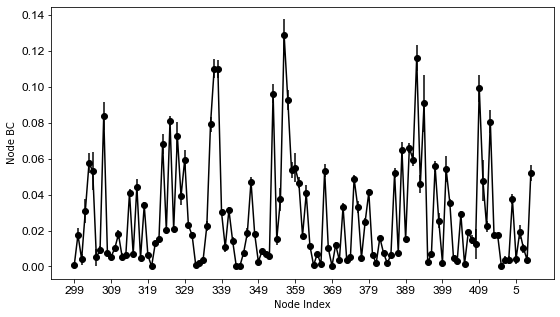

In [6]:
import matplotlib.pyplot as plt
from matplotlib import cm

BC = np.loadtxt(file_name_wh_ex+"_node_BC.dat") #Load the data
fig, ax = plt.subplots(figsize=(9,5))
ax.set_ylabel('Node BC'); #set label names
ax.set_xlabel('Node Index');
plt.yticks(fontsize=12, fontname = "Arial")
plt.xticks(fontsize=12, fontname = "Arial")
plt.xticks(np.arange(0,residue_number,10), residues[0:-1:10])
ax.errorbar(np.arange(residue_number), BC[:,0], BC[:,1], color='black', ecolor='black', marker= 'o'); # plot x, y and errors
plt.show()
plt.close()

### Segment by segment co-occupancy fraction over the MD trajectory

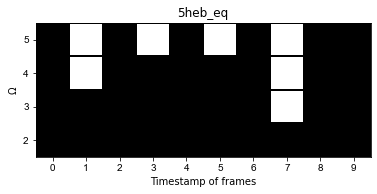

In [7]:
plt.title(file_name_wh_ex) #set the title

plt.pcolormesh(np.loadtxt(file_name_wh_ex+"_comm_btw_segments.dat").T, edgecolors='k', linewidth=1, 
               cmap=cm.binary, vmin=0.00001) # load the data and plot
ax = plt.gca()
ax.set_aspect('equal')
plt.xticks(np.arange(0.5, conf_size+0.5),np.arange(conf_size)) # set the ticks of x axis
plt.yticks(np.arange(0.5, max_community_size-0.5),np.arange(max_community_size-1)+2 ) # set the ticks of y axis

plt.yticks(fontsize=10, fontname = "Arial")
plt.xticks(fontsize=10, fontname = "Arial")
#plt.grid(color='black', linestyle='-', linewidth=1) # set the grid thickness
ax.set_ylabel(r'$\Omega$'); #set label names
ax.set_xlabel('Timestamp of frames');
#plt.savefig(file_name_wh_ex+"_comm_btw_segments", dpi=600, bbox_inches='tight') #comment in if you want to save the graph
plt.show()
plt.close()

### Calculate the average community sharing between two segments for $\Omega$ = 5

In [8]:
#Load the data from the previous computation
segment_btw_comm = np.loadtxt(file_name_wh_ex+"_comm_btw_segments.dat")
#Here is the tricky one, rows indicate the frames of MD-trajectory, by putting ':', we take all of the frames into account.
#For omega = 5, we write '3' to the column part, since indices start with '0' in python, the first column will have the information for omega = 2.
#So by writing '3' to the column section, we do the calculation for omega = 5.
mean = np.mean(segment_btw_comm[:,3])
#There are 10 frames (now here is a variable), so for error we normalize std by sqare-root of the frame count
std_err = np.std(segment_btw_comm[:,3])/np.sqrt(conf_size-1)
#Let's print the output
print('{}: {:.2f} ± {:.2f}'.format("DHRF WT with DHF broken edges for omega = 5",mean, std_err))

DHRF WT with DHF broken edges for omega = 5: 0.60 ± 0.16


### Average residue by residue co-occupancy fraction

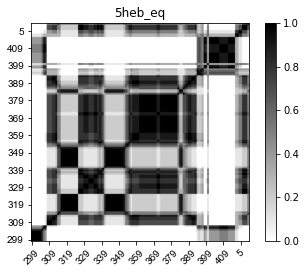

In [9]:
full_mat_tot = np.loadtxt(file_name_wh_ex+"_community_4_res_by_res_matrix.dat") #let's load the data for omega=4
plt.title(file_name_wh_ex) # set title
plt.imshow(full_mat_tot, cmap=cm.binary, origin='lower', vmin=0, vmax=1) # plot the heatmap
cbar = plt.colorbar() # Don't forget the colorbar
ax = plt.gca()
ax.set_aspect('equal')


plt.yticks(np.arange(0,residue_number,10), residues[0:-1:10]) #Arrange the ticks
plt.xticks(np.arange(0,residue_number,10), residues[0:-1:10])

plt.yticks(fontsize=10, fontname = "Arial")
plt.xticks(fontsize=10, fontname = "Arial", rotation=45)
#plt.savefig(file_name_wh_ex+"_community_4_res_by_res_matrix", dpi=600, bbox_inches='tight') # comment in to save the plot
plt.show()
plt.close()
        

### Here we write the vmd file contains the RGB coloring information.

In [10]:
full_mat_tot = np.loadtxt(file_name_wh_ex+"_rgb_data_matrix.dat")
full_mat_tot = np.round(full_mat_tot, decimals=1)
full_mat_tot_row_sums = np.sum(full_mat_tot, axis=1)
full_mat_tot = full_mat_tot/full_mat_tot_row_sums[:, np.newaxis];
full_mat_tot[np.isnan(full_mat_tot)] = 0
full_mat_tot = np.round(full_mat_tot, decimals=1)
full_mat_tot_uniq = np.unique(full_mat_tot, axis=0)

coloria = red+blue+green

f = open(file_name_wh_ex+"_color.vmd", 'w')
f.write("""
display projection Orthographic
color change rgb  32 1 1 1 
color Display Background 32
axes location Off
display depthcue off
color scale method RGB
\n
""")
f.write("mol new {}.pdb\n".format(str(file_name_wh_ex)))
f.write("mol modstyle 0 0 NewCartoon {0.300000 50.000000 4.100000 0}\n")

for i in range(len(full_mat_tot_uniq)):
    f.write("color change rgb  {:d} {:03.1f} {:03.1f} {:03.1f}\n".format(i, full_mat_tot_uniq[i][0], full_mat_tot_uniq[i][1], full_mat_tot_uniq[i][2]))
    f.write("mol addrep 0\n")
    f.write("mol modselect {:d} 0 resid {}\n".format(i+1,' '.join(map(str, residues[np.where(np.all(full_mat_tot==full_mat_tot_uniq[i], axis=1))[0]]))))
    f.write("mol modstyle {:d} 0 NewCartoon {{0.300000 50.000000 4.100000 0}}\n".format(i+1))
    f.write("mol modcolor {:d} 0 ColorID {:d}\n".format(i+1,i))
    

f.write("mol addrep 0\n")
f.write("mol modselect {:d} 0 resid {} and name CA\n".format(int(len(full_mat_tot_uniq)+1), red[0]))
f.write("mol modstyle {:d} 0 CPK {{6.000000 0.300000 40.000000 40.000000}}\n".format(int(len(full_mat_tot_uniq)+1)))
f.write("mol modcolor {:d} 0 ColorID {:d}\n".format(int(len(full_mat_tot_uniq)+1),np.where(np.all(full_mat_tot_uniq == full_mat_tot[np.where(residues == red[0])], axis=1))[0][0]))

f.write("mol addrep 0\n")
f.write("mol modselect {:d} 0 resid {} and name CA\n".format(int(len(full_mat_tot_uniq)+2), blue[0]))
f.write("mol modstyle {:d} 0 CPK {{6.000000 0.300000 40.000000 40.000000}}\n".format(int(len(full_mat_tot_uniq)+2)))
f.write("mol modcolor {:d} 0 ColorID {:d}\n".format(int(len(full_mat_tot_uniq)+2),np.where(np.all(full_mat_tot_uniq == full_mat_tot[np.where(residues == blue[0])], axis=1))[0][0]))

f.write("mol addrep 0\n")
f.write("mol modselect {:d} 0 resid {} and name CA\n".format(int(len(full_mat_tot_uniq)+3), green[0]))
f.write("mol modstyle {:d} 0 CPK {{6.000000 0.300000 40.000000 40.000000}}\n".format(int(len(full_mat_tot_uniq)+3)))
f.write("mol modcolor {:d} 0 ColorID {:d}\n".format(int(len(full_mat_tot_uniq)+3),np.where(np.all(full_mat_tot_uniq == full_mat_tot[np.where(residues == green[0])], axis=1))[0][0]))

f.close()



<ipython-input-10-4419edf31f06>:4: RuntimeWarning: invalid value encountered in true_divide
  full_mat_tot = full_mat_tot/full_mat_tot_row_sums[:, np.newaxis];
